Import the data set of the store information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import timeit
import re
from IPython.display import display
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

# import file 'store.csv'
store_data = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv')

/Users/yen/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Convert date time to features:

In [3]:
# cahnge the data format of the date
data_transactiondate = train_data['Date'].tolist()
year = []
month = []
date = []

for i in data_transactiondate:
    year.append(int(i[0:4]))
    month.append(int(i[5:7]))
    date.append(int(i[8:10]))
        
date_data = pd.DataFrame({'year':year, 'month':month, 'date':date}, columns = ['year', 'month', 'date'])
train_data.drop('Date', axis=1, inplace=True)
date_concat = pd.concat([train_data, date_data], axis=1)
train_data = date_concat

Merge store_data and train_data.

In [4]:
merge_data = pd.merge(store_data, train_data, on='Store', how='outer')

In [5]:
merge_data_1 = pd.merge(store_data, train_data, on='Store', how='outer')

Merge StoreType and Assortment to one feature.

In [6]:
storemode_list = []
for i in range(len(store_data.index)):
    j = store_data['StoreType'].loc[i]
    k = store_data['Assortment'].loc[i]
    storemode_list.append(j + k)
  
storemode = pd.DataFrame(storemode_list, columns=['storemode'])

In [7]:
storemode['Store'] = storemode.index 
merge_data = pd.merge(merge_data, storemode, on='Store', how='outer')

Convert date time to features:

In [8]:
print list(merge_data)

['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'year', 'month', 'date', 'storemode']


In [9]:
merge_data = merge_data[(merge_data['Sales'].notnull())]

In [10]:
# remove all rows that were closed 
merge_data = merge_data[merge_data['Open'] != 0]

In [11]:
sales = merge_data['Sales']

In [12]:
# drop unnecessary columns
merge_data.drop(['Sales', 'Customers']
                 , axis=1, inplace=True)

In [13]:
# use median to replace NaN for numerical column
numeric_column_heads = ['Promo2SinceYear', 'CompetitionDistance', 'CompetitionOpenSinceYear',
                        'year', 'month', 'date', 'DayOfWeek', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek']
numeric_columns = merge_data[numeric_column_heads]
categorical_columns = merge_data.drop(numeric_column_heads, axis=1)

imputer = Imputer(strategy='median')
imputer.fit(numeric_columns)
numeric_columns_X = imputer.transform(numeric_columns)
numeric_columns_tr = [pd.DataFrame(numeric_columns_X, columns=numeric_column_heads)]

categorical_columns.fillna('nan', inplace=True)
categorical_columns_tr = []
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
for h in categorical_columns:
    col_encoded = label_encoder.fit_transform(categorical_columns[h])
    col_1hot = one_hot_encoder.fit_transform(col_encoded.reshape(-1, 1))
    col = pd.DataFrame(col_1hot.toarray())
    col = col.add_prefix(h)
    categorical_columns_tr.append(col)
    
features = pd.concat(numeric_columns_tr + categorical_columns_tr, axis=1)

In [14]:
features['year_1'] = (2015 - features['year'])
features.drop(['year'], axis=1, inplace=True)

In [15]:
# normalize
x = features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features = pd.DataFrame(x_scaled, columns=features.columns)

In [16]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error, make_scorer

x_train, x_test, y_train, y_test = train_test_split(features, sales, test_size = 0.2, random_state = 26)

In [19]:
start = timeit.default_timer()

In [20]:
# classifier
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

clf_rft = ensemble.RandomForestRegressor(#n_estimators = 100,
                                        random_state = 26)

clf_rft.fit(x_train, y_train)
y_pred = clf_rft.predict(x_test)

In [21]:
y_test_ = y_test.tolist()
y_pred_ = y_pred.tolist()

In [22]:
x = []
for i in range(len(y_test)):
    y = y_test_[i]
    yhat = y_pred_[i]
    if y != 0 and yhat != 0:
        x.append(((y - yhat) / y) ** 2)
rmspe_error = sqrt(np.mean(x))
print 'RMSPE Score: ' + str(rmspe_error)

r2_scores = r2_score(y_test_, y_pred_)
print 'R2 Score: ' + str(r2_scores)

RMSPE Score: 0.142863250661
R2 Score: 0.903997659468


In [23]:
stop = timeit.default_timer()
print 'run time: ' + str(stop - start)

run time: 1047.03021002


In [24]:
importance = clf_rft.feature_importances_
feature_importances = {}
for imp, col in sorted(zip(importance, x_train.columns), reverse=True):
    if imp != 0:        
        feature_importances[col] = [imp]
    
importances_data = pd.DataFrame.from_dict(feature_importances)
importances_data = importances_data.T
importances_data.columns = ['value']
importances_data.sort('value', ascending=False, inplace=True)

importances_data_ra = importances_data[(importances_data >= 0.0002)]

print importances_data_ra

                              value
Promo1                     0.080962
CompetitionDistance        0.077924
DayOfWeek                  0.064870
Promo0                     0.054349
date                       0.052591
month                      0.046695
CompetitionOpenSinceYear   0.027260
Store816                   0.021944
Promo2SinceWeek            0.020402
StoreType1                 0.019821
CompetitionOpenSinceMonth  0.019723
Store1113                  0.018070
year_1                     0.015412
Promo2SinceYear            0.015167
Store261                   0.014286
Store512                   0.012955
Store250                   0.012486
Store787                   0.011469
Store841                   0.010355
Assortment2                0.009626
Store382                   0.008742
Assortment0                0.008019
Store697                   0.007639
Store755                   0.006595
Store379                   0.006480
Store594                   0.006303
StoreType0                 0

/Users/yen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [25]:
l = []
for i in range(1115):
    i += 1
    merge_data_2 = merge_data_1
    merge_data_2 = merge_data_1[merge_data_2['Store'] == i]
    a = merge_data_2['Sales'].mean()
    l.append(a)

n = []
for i in range(1115):
    i += 1
    n.append(i)
    
mean_data = pd.DataFrame({'Store':n, 'MeanSales':l}, columns=['Store', 'MeanSales'])

In [26]:
merge_data_3 = pd.merge(store_data, train_data, on='Store', how='outer')
merge_data_4 = pd.merge(merge_data_3, mean_data, on='Store', how='outer')
print display(merge_data_4.head(3))

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,date,MeanSales
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,5263,555,1,1,0,1,2015,7,31,3945.704883
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,5020,546,1,1,0,1,2015,7,30,3945.704883
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,4782,523,1,1,0,1,2015,7,29,3945.704883


None


In [27]:
x_test_index = x_test.index.values.tolist()

mean_data_pred = []
for i in x_test_index:
    j = merge_data_4.iloc[0]['MeanSales']
    mean_data_pred.append(j)

In [28]:
x = []
for i in range(len(y_test)):
    y = y_test_[i]
    yhat = mean_data_pred[i]
    if y != 0 and yhat != 0:
        x.append(((y - yhat) / y) ** 2)
rmspe_error = sqrt(np.mean(x))
print 'RMSPE Score: ' + str(rmspe_error)

r2_scores = r2_score(y_test_, mean_data_pred)
print 'R2 Score: ' + str(r2_scores)

RMSPE Score: 0.454630163643
R2 Score: -0.944969787


Text(0,0.5,u'RMSPE Score')

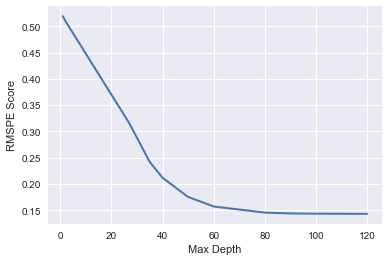

In [29]:
x = [1, 2, 27, 35, 40, 50, 60, 80, 90, 100, 120]
y = [0.519101118894, 0.510105350151, 0.315338383689, 0.241596348998, 0.21165359609, 0.175109607934, 0.156937563399, 0.145316793498, 0.143742410698, 0.14327112879, 0.142898617358]

plt.plot(x, y, linewidth=2.0)
plt.xlabel('Max Depth')
plt.ylabel('RMSPE Score')

n=10;0.454630163643
n=10;weekday;0.454630163643
